### Initialize the client

As seen in the "1kg.ipynb" example, we take the following steps to create the client object that will be used to obtain the information we desire and query the server. Plotting tools are also imported here.

In [1]:
import ga4gh.client as client
c = client.HttpClient("http://1kgenomes.ga4gh.org")

import sys
import collections
import math
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import ipywidgets as widgets

### Acquiring annotation set

We query the server for the dataset, which is the 1k-genomes dataset. The dataset has a unique ID that can be used to acquire each variant set within the dataset. 

To access the different kinds of annotations, we access the annotation set using the unique variant set ID.

In [2]:
dataset = c.searchDatasets().next()

for variantSet in c.searchVariantSets(dataset.id):
    if variantSet.name == "functional-annotation":
        annotation = variantSet

annotationSet = c.searchVariantAnnotationSets(variantSetId=annotation.id).next()

### Running Search

runSearch is called below using ipywidgets. Some global variables are initialized for other functions to use and the start and end points are set based on how many buckets the user wants. The function then searches for the transcript effects, given the transcript effect the user is looking for.

In [3]:
def runSearch(startPos, endPos, chromosome, searchTerms, buckets):
    
    global formatSearch 
    formatSearch = []
    
    for i in range(0,len(searchTerms)):
        formatSearch.append({"id":searchTerms[i]})
    
    global windowCount
    windowCount = int(buckets)
    
    global initStart
    global initEnd
    initStart = startPos
    initEnd = endPos
    startPoint = int(startPos)
    endPoint = (int(startPos)+(int(endPos)-int(startPos))/int(buckets))
    
    global yList
    global xTickList
    yList=[]
    xTickList=[]
    
    for i in range(0,windowCount):
        
        searchedVarAnns=c.searchVariantAnnotations(variantAnnotationSetId=annotationSet.id, start=startPoint, end=endPoint, referenceName=chromosome, effects=formatSearch)
    
        idList = []
        startEndList = []
        
        for annotation in searchedVarAnns:
            #print(annotation)
            idList.append(annotation.variant_id)
    
        for ids in idList:
            important = c.getVariant(ids)
            startEndList.append(important.start)
            startEndList.append(important.end)
        countingStats(seVals=startEndList, windowValue=windowCount, yValList=yList, startPos=startPoint, endPos=endPoint)
        
        startPoint+=(int(endPos)-int(startPos))/int(buckets)
        endPoint+=(int(endPos)-int(startPos))/int(buckets)
        del idList[:]
        del startEndList[:]
    

### Counting Statistics

countingStats arranges the data in a way that will work nicely with matplotlib. The values are then passed onto the plotting function.

In [4]:
def countingStats(seVals, windowValue, yValList,startPos, endPos):
    values = np.empty([int(len(seVals))/2,2], dtype=np.int32)
    
    j=0
    k=1
    for i in range(0,int(len(seVals))/2):
        values[i][0] = seVals[j]
        values[i][1] = seVals[k]
        j+=2
        k+=2
    
    yList.append(len(values))
    
    xTickList.append(values)
    
    if len(yList)==windowValue:
        plotWindowHistogram(xTickList, yList, windowValue, startPos, endPos)

### Plotting

All the statistics are gathered and then graphed. The function creates different graph titles depending on what effects and regions the user searches.

In [5]:
def plotWindowHistogram(xAxisTicks, yAxisValues, windowVals, startPos, endPos):
    
    fig, ax = plt.subplots()
    
    endValues = np.empty([1,2], dtype=np.int32)

    endValues[0][0] = startPos
    endValues[0][1] = endPos
    
    ax.set_xticklabels(endValues, rotation=90)
    
    for i in range(0,windowVals):
        plt.bar(i, yAxisValues[i], width=1, color=['maroon'])
    
    #h = plt.bar(xrange(len(xAxisTicks)), yAxisValues, label=xAxisTicks)
    #xticks_pos = [0.50*patch.get_width() + patch.get_xy()[0] for patch in h]
    #plt.xticks(xticks_pos, xAxisTicks,  ha='right', rotation=45)
    
    # title and graph size formatting
    title=""
    if len(formatSearch)==1:
        ax.set_title(str(formatSearch[0]['id'])+" from "+str(initStart)+" to "+str(initEnd))
    else:
        for i in range(0,len(formatSearch)):
            if i!=(len(formatSearch)-1):
                title+=str(formatSearch[i]['id'])+", "
            else:
                title+="and "+str(formatSearch[i]['id'])+" "
        ax.set_title(title+"from "+str(initStart)+" to "+str(initEnd))
        
    ax.set_ylim([0,int(math.ceil(max(yAxisValues)/5.0))*5])
    ax.set_xticklabels([endValues])
    plt.rcParams["figure.figsize"] = [10,10]
    
    plt.show()

### Interact Widgets

A dictionary of transcript effects and their search ontology ID's is made so that the user doesn't have to remember the ID's. runSearch is then called and the interact function gives" runSearch all of the necessary parameters based on what the user has chosen.

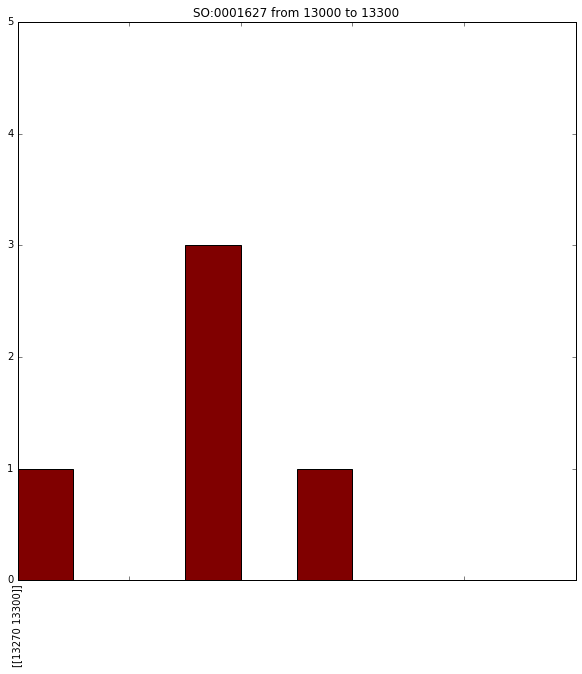

In [6]:
searchOntologyDict = {'transcript_ablation' : 'SO:0001893', 'splice_acceptor_variant' : 'SO:0001574', 'splice_donor_variant' : 'SO:0001575', 'stop_gained' : 'SO:0001587', 'frameshift_variant' : 'SO:0001589', 'stop_lost' : 'SO:0001578', 'start_lost' : 'SO:0002012', 'transcript_amplification' : 'SO:0001889', 'inframe_insertion' : 'SO:0001821', 'inframe_deletion' : 'SO:0001822', 'missense_variant' : 'SO:0001583', 'protein_altering_variant' : 'SO:0001818', 'splice_region_variant' : 'SO:0001630', 'incomplete_terminal_codon_variant' : 'SO:0001626', 'stop_retained_variant' : 'SO:0001567', 'synonymous_variant' : 'SO:0001819', 'coding_sequence_variant' : 'SO:0001580', 'mature_miRNA_variant' : 'SO:0001620', '5_prime_UTR_variant' : 'SO:0001623', '3_prime_UTR_variant' : 'SO:0001624', 'non_coding_transcript_exon_variant' : 'SO:0001792', 'intron_variant' : 'SO:0001627', 'NMD_transcript_variant' : 'SO:0001621', 'non_coding_transcript_variant' : 'SO:0001619', 'upstream_gene_variant' : 'SO:0001631', 'downstream_gene_variant' : 'SO:0001632', 'TFBS_ablation' : 'SO:0001892', 'TFBS_amplification' : 'SO:0001892', 'TF_binding_site_variant' : 'SO:0001782', 'regulatory_region_ablation' : 'SO:0001894', 'regulatory_region_amplification' : 'SO:0001891', 'feature_elongation' : 'SO:0001907', 'regulatory_region_variant' : 'SO:0001566', 'feature_truncation' : 'SO:0001906', 'intergenic_variant' : 'SO:0001628'}
shortDict = {'intron_variant' : 'SO:0001627', 'feature_truncation' : 'SO:0001906' , 'non_coding_transcript_exon_variant' : 'SO:0001792' , 'non_coding_transcript_variant' : 'SO:0001619', 'transcript_ablation' : 'SO:0001893'}
chromList = ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18')


multiSelect = widgets.SelectMultiple(
    description="Transcript Effects",
    options=shortDict
)

interact(runSearch,
         startPos="13000",
         endPos="13300",
         chromosome=chromList,
         searchTerms=multiSelect,
         buckets="10",
         __manual="True"
         )